Nama : Erin Nur Fatimah

Id : M515Y1092

Path : Pengembang Machine Learning dan Front-End (M02)

No WhatsApp : 083149731170

Email : 203110024@students.akakom.ac.id

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
dfr = pd.read_csv('/content/drive/MyDrive/data set/data set proyek 2/daily-minimum-temperatures-in-me.csv')
dfr

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8
...,...,...
3645,12/27/1990,14.0
3646,12/28/1990,13.6
3647,12/29/1990,13.5
3648,12/30/1990,15.7


In [5]:
dfr.isnull().any()

Date                          False
Daily minimum temperatures    False
dtype: bool

In [6]:
dates = dfr['Date'].values
temp = dfr['Daily minimum temperatures'].values
data = temp.reshape(-1, 1)

scaler = MinMaxScaler()
label = scaler.fit(data)
label = scaler.fit_transform(data)
label = label.flatten()
label

array([0.78707224, 0.68060837, 0.7148289 , ..., 0.51330798, 0.59695817,
       0.49429658])

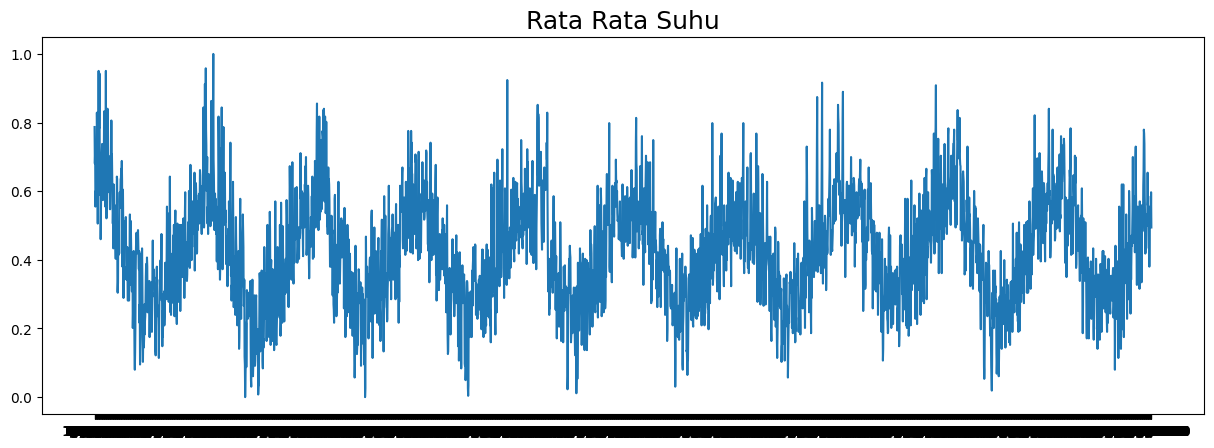

In [7]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(dates, label)
plt.title('Rata Rata Suhu',
          fontsize=18);

In [8]:
data_main, data_test, label_main, label_test = train_test_split(label, dates, test_size=0.2)  
data_latih, data_val, label_latih, label_val = train_test_split(data_main, label_main, test_size=0.2)  
data_latih

array([0.22813688, 0.25855513, 0.29657795, ..., 0.57034221, 0.49429658,
       0.58935361])

In [9]:
def windowed_data(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
train_set = windowed_data(data_latih, window_size=100, batch_size=100, shuffle_buffer=1000)
val_set = windowed_data(data_test, window_size=100, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=100, kernel_size=100, strides=2,padding="causal", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120)),
    tf.keras.layers.Dense(1),
])

In [11]:
threshold = (dfr['Daily minimum temperatures'].max()-dfr['Daily minimum temperatures'].min())*10/100
threshold

2.63

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold):
      print("\nmae lebih kecil dari 10% data. maka training berhenti!")
      self.model.stop_training = True

callbacks = myCallback()

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.01, decay=.01)
model.compile(
            loss=tf.keras.losses.Huber(),
            optimizer=optimizer,
            metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
23/23 [==============================] - 21s 608ms/step - loss: 0.0306 - mae: 0.1712
Epoch 2/500
23/23 [==============================] - 14s 605ms/step - loss: 0.0124 - mae: 0.1267
Epoch 3/500
23/23 [==============================] - 14s 609ms/step - loss: 0.0122 - mae: 0.1260
Epoch 4/500
23/23 [==============================] - 14s 608ms/step - loss: 0.0123 - mae: 0.1265
Epoch 5/500
23/23 [==============================] - 14s 602ms/step - loss: 0.0123 - mae: 0.1264
Epoch 6/500
23/23 [==============================] - 16s 695ms/step - loss: 0.0121 - mae: 0.1254
Epoch 7/500
23/23 [==============================] - 14s 602ms/step - loss: 0.0121 - mae: 0.1250
Epoch 8/500
23/23 [==============================] - 14s 595ms/step - loss: 0.0121 - mae: 0.1253
Epoch 9/500
23/23 [==============================] - 14s 606ms/step - loss: 0.0121 - mae: 0.1251
Epoch 10/500
23/23 [==============================] - 14s 603ms/step - loss: 0.0121 - mae: 0.1255
Epoch 11/500
23/23 [=========

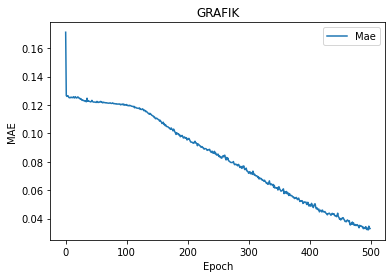

In [20]:
plt.plot(history.history['mae'], label="Mae")
plt.title('GRAFIK')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()